# Проект Дашборд конверсий

## Загрузка библиотек, получение данных, определение переменных окружения

In [1]:
import os
import numpy as np
import math
import pandas as pd
import requests as req
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dotenv import load_dotenv

load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

resp = req.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})
resp_visits = req.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})

In [2]:
if not os.path.isdir('./charts'): os.mkdir("charts")

## Чтение зарегистрированных и посещаемых пользователей

In [3]:
visitors = pd.DataFrame(resp_visits.json())
regs = pd.DataFrame(resp.json())
visitors['datetime'] = pd.to_datetime(visitors['datetime']).dt.date
regs['datetime'] = pd.to_datetime(regs['datetime']).dt.date

In [4]:
regs.head()

,datetime,user_id,email,platform,registration_type
0,2023-03-01,2e0f6bb8-b029-4f45-a786-2b53990d37f1,ebyrd@example.org,web,google
1,2023-03-01,f007f97c-9d8b-48b5-af08-119bb8f6d9b6,knightgerald@example.org,web,email
2,2023-03-01,24ff46ae-32b3-4a74-8f27-7cf0b8f32f15,cherylthompson@example.com,web,apple
3,2023-03-01,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email
4,2023-03-01,27f875fc-f8ce-4aeb-8722-0ecb283d0760,denise86@example.net,web,google


In [5]:
visitors.head(10)

,visit_id,platform,user_agent,datetime
0,1de9ea66-70d3-4a1f-8735-df5ef7697fb9,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
1,f149f542-e935-4870-9734-6b4501eaf614,web,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,2023-03-01
2,08f0ebd4-950c-4dd9-8e97-b5bdf073eed1,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,2023-03-01
3,19322fed-157c-49c6-b16e-2d5cabeb9592,web,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,2023-03-01
4,04762a22-3c9f-40c9-9ac9-6628c4381836,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
5,040e1e30-c9ed-4248-bc97-99a707e36d60,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
6,7bf78a4d-9f8f-4ffb-a5f8-0a0a58994953,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
7,175e9941-2607-4d5f-b6ab-14759da618fd,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
8,d868c2cf-1d4a-4b12-b6a2-0bb02edf0743,web,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,2023-03-01
9,e1668271-7c9b-4fae-80ca-17b703be0e66,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,2023-03-01


## Фильтрация и группировка посещаемых пользователей по признакам

In [6]:
visitors = visitors.sort_values(by=['visit_id', 'datetime']).drop_duplicates(subset='visit_id', keep='last')
visitors = visitors[visitors['user_agent'].apply(lambda x: 'bot' not in x)]

In [7]:
grouped_visitors = visitors.groupby(['platform', 'datetime'])['datetime'].count().reset_index(name='visits')

In [8]:
grouped_visitors.head()

,platform,datetime,visits
0,android,2023-03-01,75
1,android,2023-03-02,67
2,android,2023-03-03,26
3,android,2023-03-04,94
4,android,2023-03-05,66


### График итоговых визитов

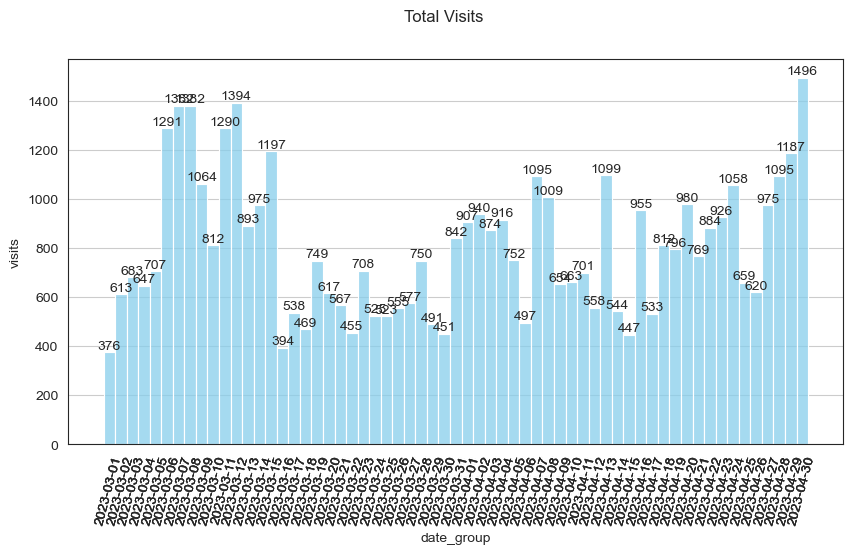

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
fig.suptitle("Total Visits")
ax.grid(axis='y')
sns.set_style("white")
ax = sns.histplot(x="datetime", data=visitors, color='skyblue')
ax.set_xticks(grouped_visitors['datetime'])
plt.xticks(rotation = 75)
plt.xlabel('date_group')
plt.ylabel('visits')
ax.bar_label(ax.containers[0])
plt.savefig('./charts/total_visits.png')

### График итоговых визитов с разбивкой по платформе

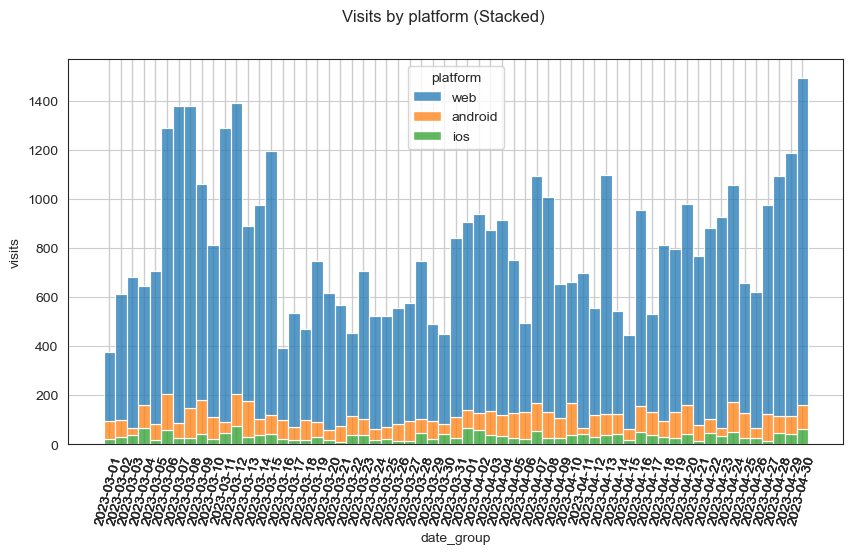

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
fig.suptitle("Visits by platform (Stacked)")
ax.grid()
ax = sns.histplot(data=visitors, x="datetime", hue='platform', multiple='stack')
ax.set_xticks(grouped_visitors['datetime'])
plt.xlabel('date_group')
plt.ylabel('visits')
plt.xticks(rotation = 75)
plt.savefig('./charts/visitors_by_platform.png')

Как видно из графиков визитов за данный период, наибольшее количество визитов происходило в праздничные и предпраздничные дни марта
и предпразничные дни в конце апреля. Наибольшее количество всех посещений было с web платформ, самое наименьшее значение -- с лпатформы ios.
Исходя из этого можно сделать вывод, что наибольший интерес к ресурсу происхожит в выходные дни, когда людям удобно обращаться на ресурс с десктопных приложений.
Сам же по себе ресурс привлекает, поэтому необходимо провести работы, по улучшению и привлекательности интерфейса с мобильных платформ, 
для поднятия интереса публики в рабочее и любое другое время и привлечения потенциальных клиентов.

## Группировка зарегистрированных пользователей

In [56]:
grouped_regs = regs.groupby(['platform', 'datetime'])['datetime'].count().reset_index(name='registrations')

In [57]:
grouped_regs.head()

,platform,datetime,registrations
0,android,2023-03-01,61
1,android,2023-03-02,59
2,android,2023-03-03,22
3,android,2023-03-04,77
4,android,2023-03-05,54


### График итоговых регистраций

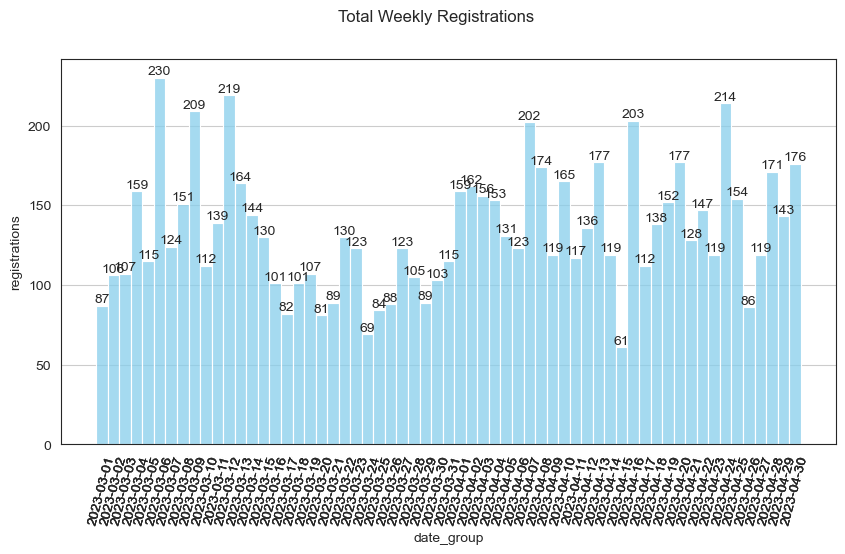

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
fig.suptitle("Total Weekly Registrations")
ax.grid(axis='y')
sns.set_style("white")
ax = sns.histplot(x="datetime", data=regs, color='skyblue')
ax.set_xticks(grouped_regs['datetime'])
plt.xticks(rotation = 75)
plt.xlabel('date_group')
plt.ylabel('registrations')
ax.bar_label(ax.containers[0])
plt.savefig('./charts/total_regs.png')

### Итоговые регистрации с разбивкой по платформе

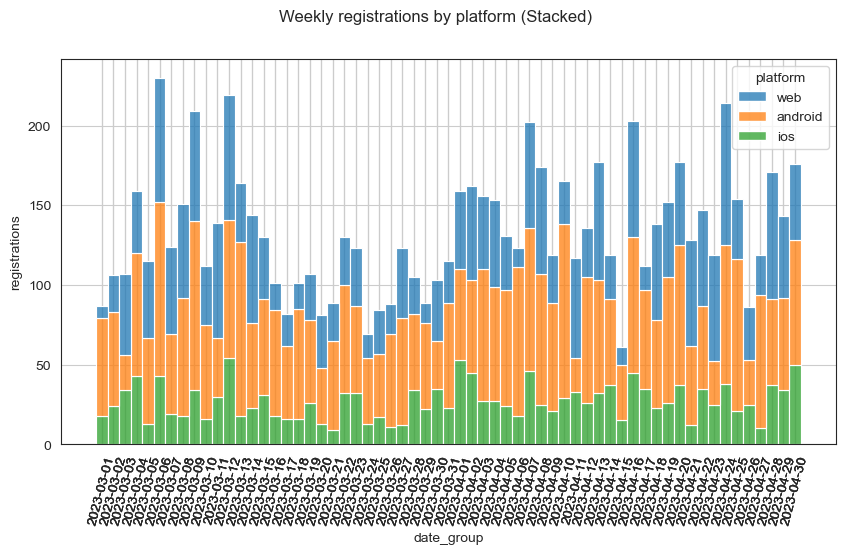

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
fig.suptitle("Weekly registrations by platform (Stacked)")
ax.grid()
ax = sns.histplot(data=regs, x="datetime", hue='platform', multiple='stack')
ax.set_xticks(grouped_regs['datetime'])
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.xticks(rotation = 75)
plt.savefig('./charts/registrations_by_platform.png')

Исходя из графиков выше можно сделать вывод, что регистрация напрямую зависит от почещаемости платформы с небольшим отклонгениями.
Большинство регистраций происходит с мобильной платформы, которая имеете дружелюбный интерфейс и удобство для использования. Здесь ничего поравлять не нужно.

## Слияние таблиц и расчет полной конверсии

In [60]:
conversion = pd.merge(
    grouped_visitors, grouped_regs
)
total_conversion = conversion.rename(columns={'datetime': 'date_group'})
total_conversion.sort_values(by=['date_group', 'platform'], inplace=True)
total_conversion = total_conversion.reset_index(drop=True)
total_conversion = total_conversion.groupby('date_group', as_index=False).sum()
total_conversion['conversion'] = (total_conversion['registrations'] / total_conversion['visits']) * 100
total_conversion.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,androidiosweb,376,87,23.138298
1,2023-03-02,androidiosweb,613,106,17.292007
2,2023-03-03,androidiosweb,683,107,15.666179
3,2023-03-04,androidiosweb,647,159,24.574961
4,2023-03-05,androidiosweb,707,115,16.265912


### График полной конверсии

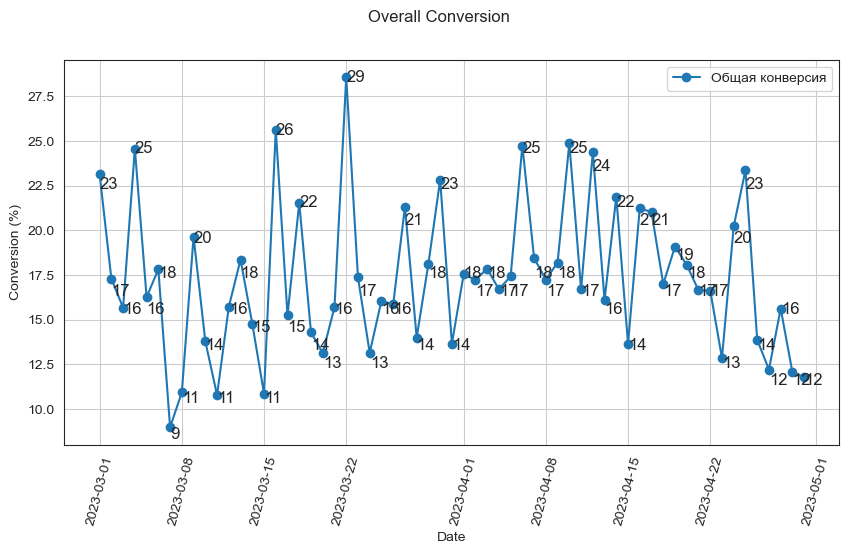

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
fig.suptitle("Overall Conversion")
ax.grid()
x = total_conversion['date_group']
y = total_conversion['conversion']
ax.plot('date_group', 'conversion', data=total_conversion, marker='o', label='Общая конверсия')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.xticks(rotation = 75)
plt.legend()
for i, v in enumerate(y):
    ax.text(x[i], round(y[i]), round(v), fontsize=12, va='top')
# for (xi, yi) in zip(x, y):
#     plt.text(xi, round(yi), round(yi))
plt.savefig('./charts/total_conversion.png')

Согласно графику, можно понять, что падение конверсии происходит в праздничные дни. В среднем в остальные дни конверсия стабильна с небольшими пиками 15 и 22 марта.
Это говорит о том, что после больших посещений в праздничные дни пользователи не спешат регистрироватся сразу.
В основном регистрация происходит в будние дни, но и количество посещений в будние дни меньше, из-за чего конверсия выглядит стабильнее.
Вывод: ресурс привлекает множество людей, но пользоваться им спешат не все. 

## Слияние таблиц и расчет конверсии по платформам

In [62]:
conversion = pd.merge(
    grouped_visitors, grouped_regs
)
conversion = conversion.rename(columns={'datetime': 'date_group'})
conversion.sort_values(by=['date_group', 'platform'], inplace=True)
conversion = conversion.reset_index(drop=True)
conversion['conversion'] = (conversion['registrations'] / conversion['visits']) * 100
conversion.sort_values(by='date_group', inplace=True)
conversion.to_json('./conversion.json')

In [63]:
conversion.head()

,platform,date_group,visits,registrations,conversion
0,android,2023-03-01,75,61,81.333333
1,ios,2023-03-01,22,18,81.818182
2,web,2023-03-01,279,8,2.867384
3,android,2023-03-02,67,59,88.059701
4,ios,2023-03-02,31,24,77.419355


### Графики конверсий по каждой платформе

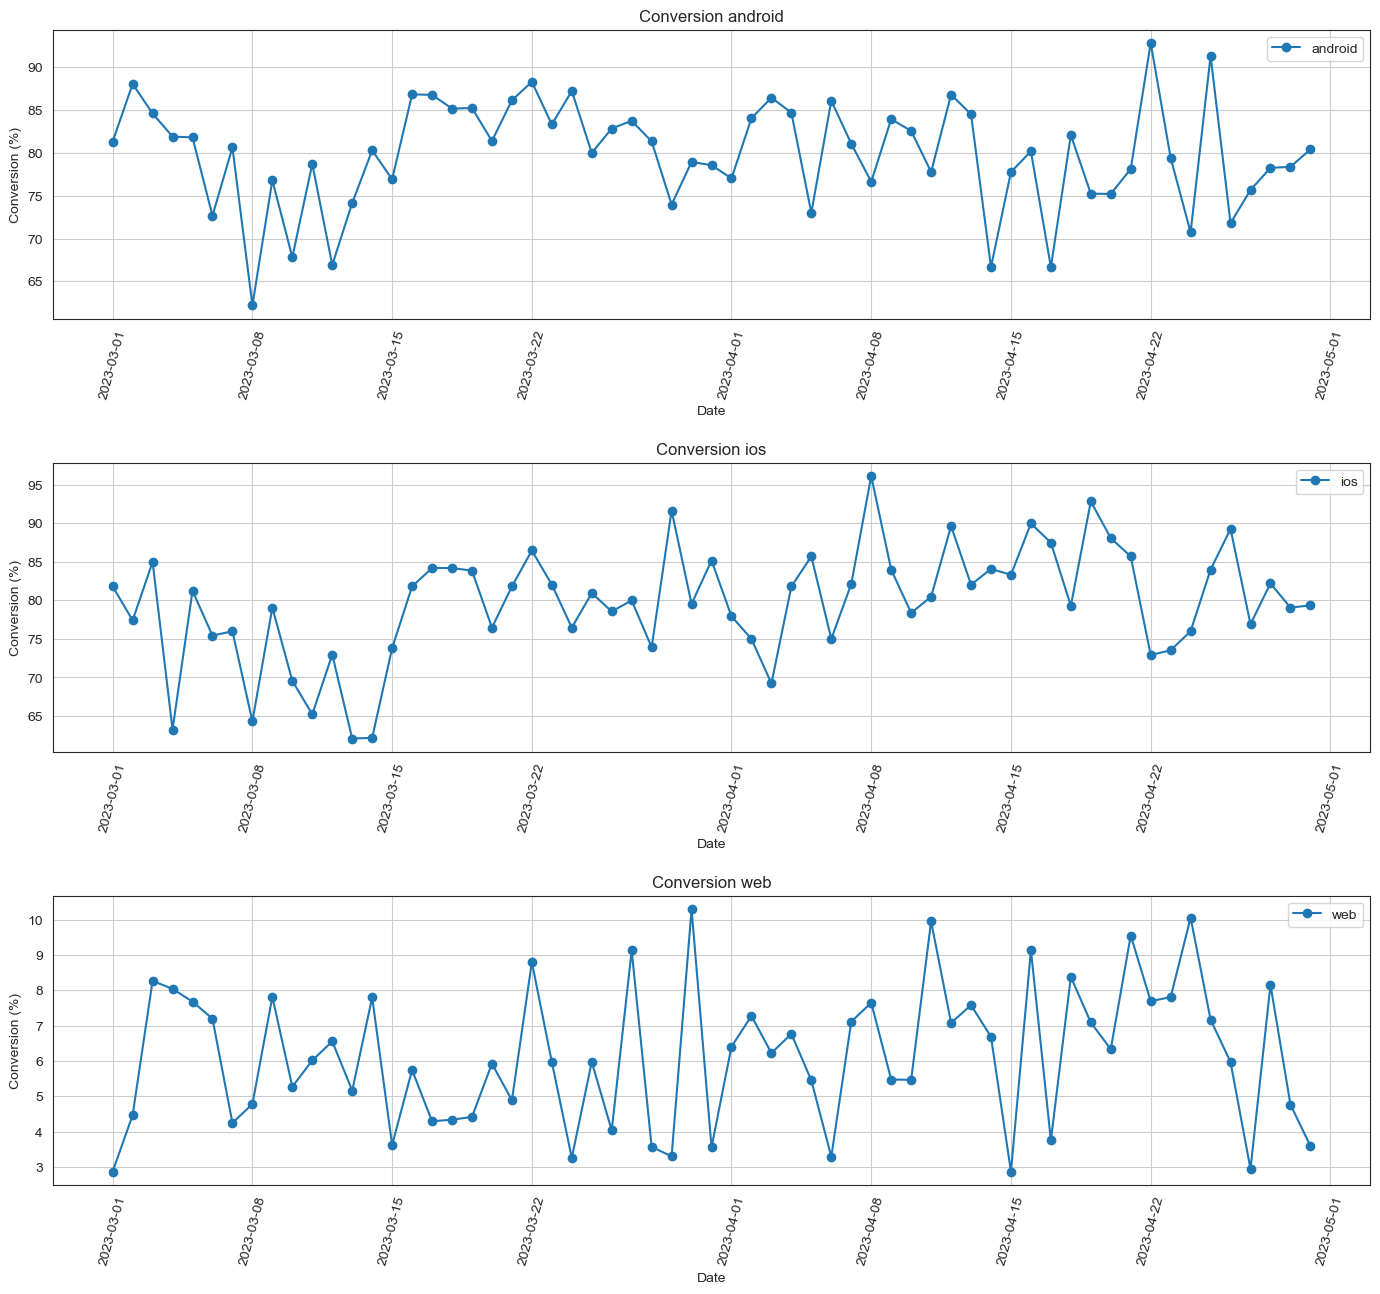

In [65]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches((17, 15))

dictionary_platforms = {
    0: (conversion[conversion['platform'] == 'android'], "Conversion android", "android"),
    1: (conversion[conversion['platform'] == 'ios'], "Conversion ios", "ios"),
    2: (conversion[conversion['platform'] == 'web'], "Conversion web", "web")
}
for n in range(3):
    x = 'date_group'
    y = 'conversion'
    platform, platform_title, platform_label = dictionary_platforms[n]
    ax[n].plot(x, y, data=platform, label=platform_label, marker='o')
    ax[n].set_xlabel('Date')
    ax[n].set_ylabel('Conversion (%)')
    ax[n].set_title(platform_title)
    ax[n].set_xticks(ax[n].get_xticks())
    ax[n].set_xticklabels(ax[n].get_xticklabels(), rotation=75)
    ax[n].legend()
    ax[n].grid()
    # for i, v in enumerate(y):
    #     ax[n].text(x[i], y[i], v, fontsize=12, va='top')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('./charts/conversion_by_platform.png')

Данные графики подтверждают вышесказанное, что конверсия лучше с мобильных устройств, что подтверждает интерфейс более дружелюбен при регистрации, чем при просмотрах.
Людям удобнее регистрироваться с мобильных устройств, чем с веба, а просмотры удобнее делать с веба.

## Загружаем данные по рекламным компаниями

In [66]:
ads = pd.read_csv('./ads.csv')

In [67]:
ads.head()

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01T10:54:41,google,cpc,advanced_algorithms_series,212
1,2023-03-02T10:32:35,google,cpc,advanced_algorithms_series,252
2,2023-03-03T19:21:40,google,cpc,advanced_algorithms_series,202
3,2023-03-04T17:52:04,google,cpc,advanced_algorithms_series,223
4,2023-03-05T05:35:13,google,cpc,advanced_algorithms_series,265


In [68]:
ads = ads[(ads['date'] >= DATE_BEGIN) & (ads['date'] <= DATE_END)]
ads['date'] = pd.to_datetime(ads['date']).dt.date
ads = ads.fillna({'utm_campaign': 'none', 'cost': 0})

### График стоимости рекламных компаний

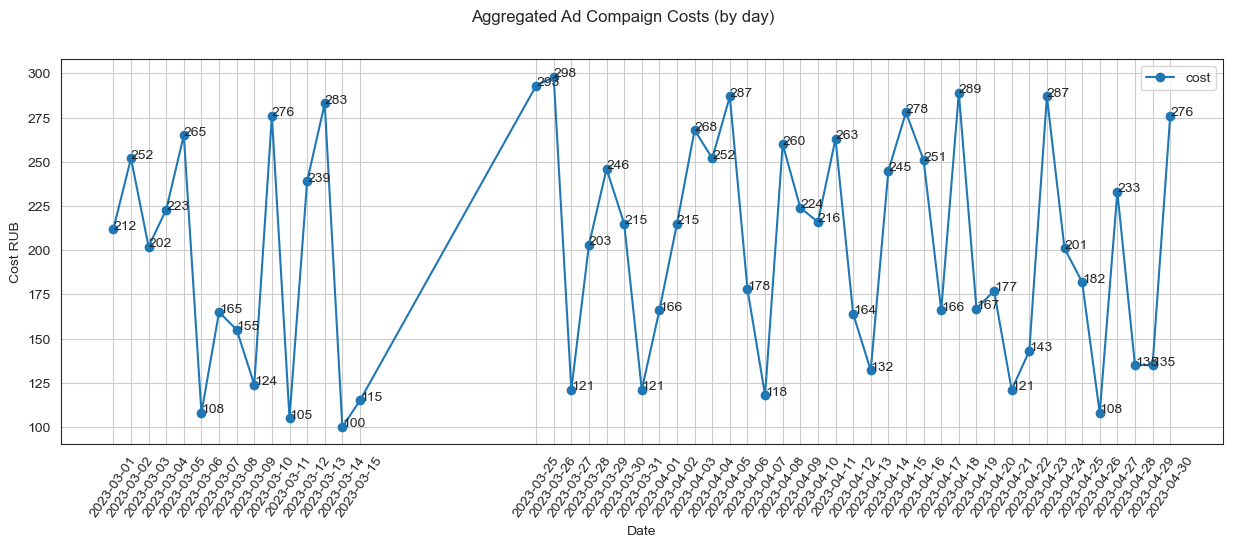

In [69]:
fig, ax = plt.subplots()
fig.set_size_inches((15, 5))
fig.suptitle("Aggregated Ad Compaign Costs (by day)")
ax.grid()
x = ads['date']
y = ads['cost']
ax.plot(x, y, data=ads, marker='o')
ax.set_xticks(ads['date'])
plt.xlabel('Date')
plt.ylabel('Cost RUB')
plt.xticks(rotation = 55)
plt.legend()
for (xi, yi) in zip(x, y):
    plt.text(xi, round(yi), round(yi))
plt.savefig('./charts/ads_cost.png')

Если посмотреть на график, то мы увидим, что пик стоимости рекламы происходит 26 марта, самые низкая стоимость -- 5 марта и вплоть до 8 числа.
В остальное время стоимость циклична. Высокая и низкия стоимость чередуются циклом 3-5 дней.

## Группируем рекламу по рекламным компаниям, объединяем с конверсией

In [70]:
conversion_ads = pd.merge(
    total_conversion, ads, left_on='date_group', right_on='date'
)
conversion_ads.sort_values(by='date_group', inplace=True)

In [71]:
conversion_ads = conversion_ads[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
conversion_ads.to_json('./ads.json')
conversion_ads.head()

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,376,87,212,advanced_algorithms_series
1,2023-03-02,613,106,252,advanced_algorithms_series
2,2023-03-03,683,107,202,advanced_algorithms_series
3,2023-03-04,647,159,223,advanced_algorithms_series
4,2023-03-05,707,115,265,advanced_algorithms_series


### Находим диапазон дат начала и конца компаний

In [72]:
min_dates = conversion_ads.groupby('utm_campaign')['date_group'].min().reset_index(name='min_date_group')
max_dates = conversion_ads.groupby('utm_campaign')['date_group'].max().reset_index(name='max_date_group')

conversion_ads = conversion_ads.merge(min_dates, on='utm_campaign', how='left')
conversion_ads = conversion_ads.merge(max_dates, on='utm_campaign', how='left')

conversion_ads.head()

,date_group,visits,registrations,cost,utm_campaign,min_date_group,max_date_group
0,2023-03-01,376,87,212,advanced_algorithms_series,2023-03-01,2023-03-15
1,2023-03-02,613,106,252,advanced_algorithms_series,2023-03-01,2023-03-15
2,2023-03-03,683,107,202,advanced_algorithms_series,2023-03-01,2023-03-15
3,2023-03-04,647,159,223,advanced_algorithms_series,2023-03-01,2023-03-15
4,2023-03-05,707,115,265,advanced_algorithms_series,2023-03-01,2023-03-15


### Графики визитов и регистраций с выделением рекламных компаний

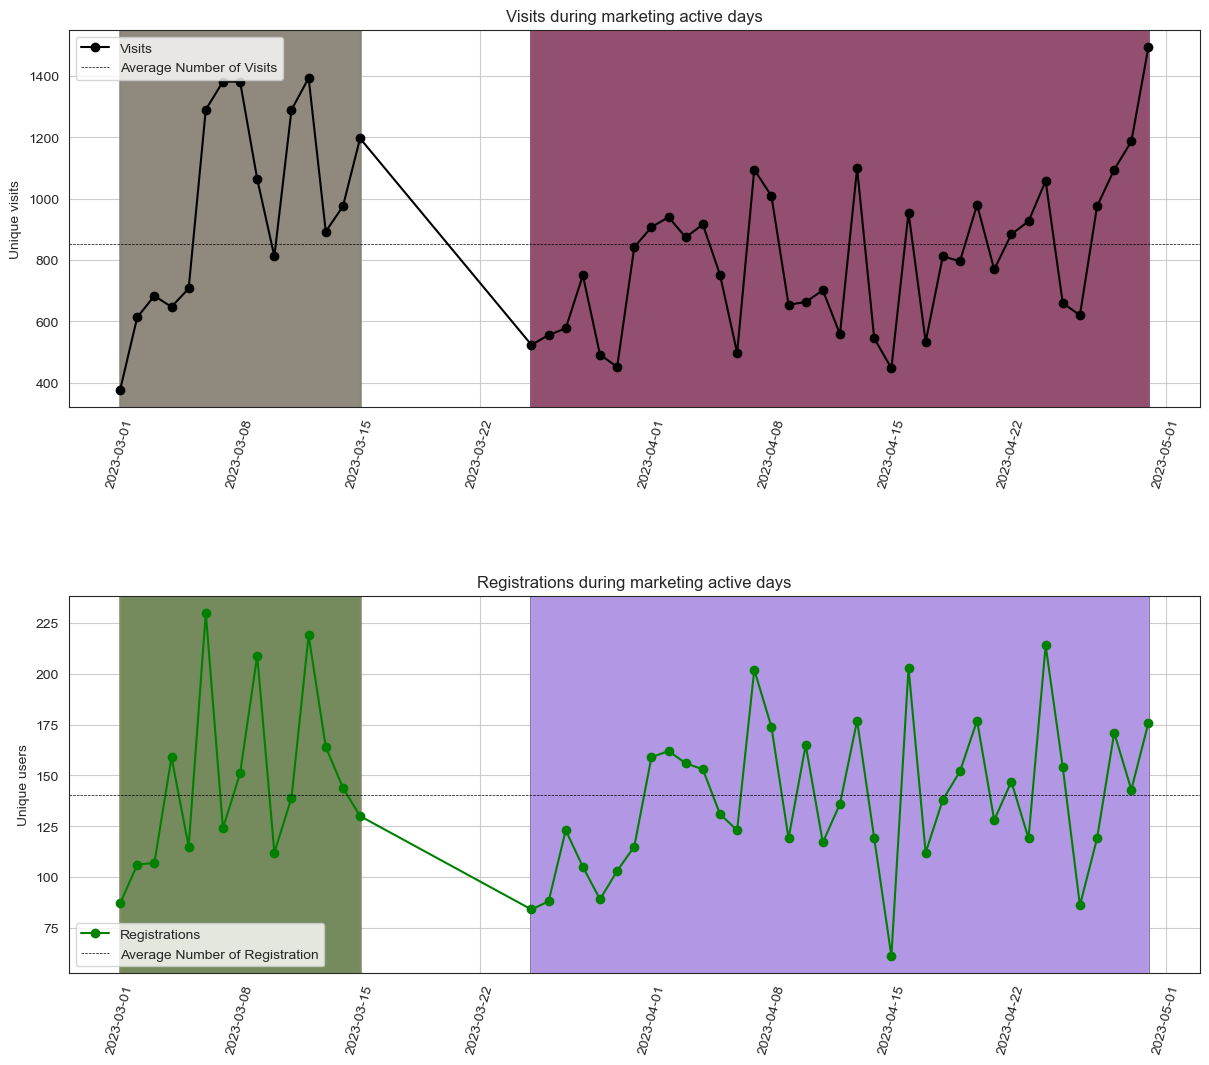

In [73]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches((12, 10))
plt.tight_layout()

dictionary_conversion_ads = {
    0: (conversion_ads['visits'], "Visits during marketing active days", "Visits", "Unique visits", 'Average Number of Visits', 'black'),
    1: (conversion_ads['registrations'], "Registrations during marketing active days", "Registrations", "Unique users", 'Average Number of Registration', 'green'),
}
for n in range(2):
    ads, ads_title, ads_label, ads_y_label, ads_mean, ads_color = dictionary_conversion_ads[n]
    x = 'date_group'
    y = ads
    ax[n].plot(x, y, data=conversion_ads, label=ads_label, marker='o', color=ads_color)
    ax[n].set_ylabel(ads_y_label)
    ax[n].set_title(ads_title)
    ax[n].set_xticks(ax[n].get_xticks())
    ax[n].set_xticklabels(ax[n].get_xticklabels(), rotation=75)
    ax[n].axhline(ads.mean(), color='black', linestyle='--', linewidth=0.5, label=ads_mean)
    
    for _, row in conversion_ads.iterrows():
        ax[n].axvspan(row['min_date_group'], row['max_date_group'], color=np.random.rand(3,), alpha=0.5)
    ax[n].legend()
    ax[n].grid()
plt.subplots_adjust(hspace = 0.5)
plt.savefig('./charts/ads_visits_registrations.png')

Проанализировав последние данные можно сделать вывод о том, что визиты и регистрации не сильно зависят от активности маркетинговых дней и прожажи рекламы.
Так потратив минимальное количество денег на рекламы мы видим роста посещений и регистраций в праздничные дни.
Тогда, как затратив больше средств на рекламу после праздников мы видим активность посещений и регистраций примерно на 10-15 % меньше.
Регистрации имеют похожий циклический характер, какм и стоимость рекламы.